# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Открытие файла с данными и изучение общей информации

In [1]:
pip install missingno # установка пакета для визуализации пропусков

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # загрузка библиотек

In [3]:
# чтение файла с разделителем
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/real_estate_data.csv', sep='\t')

Изучение общей информации из полученного датафрейма.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [5]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [6]:
data.shape

(23699, 22)

Построение общей гистограммы для всех числовых столбцов таблицы. Например, для датафрейма data это можно сделать командой `data.hist(figsize=(15, 20))`.

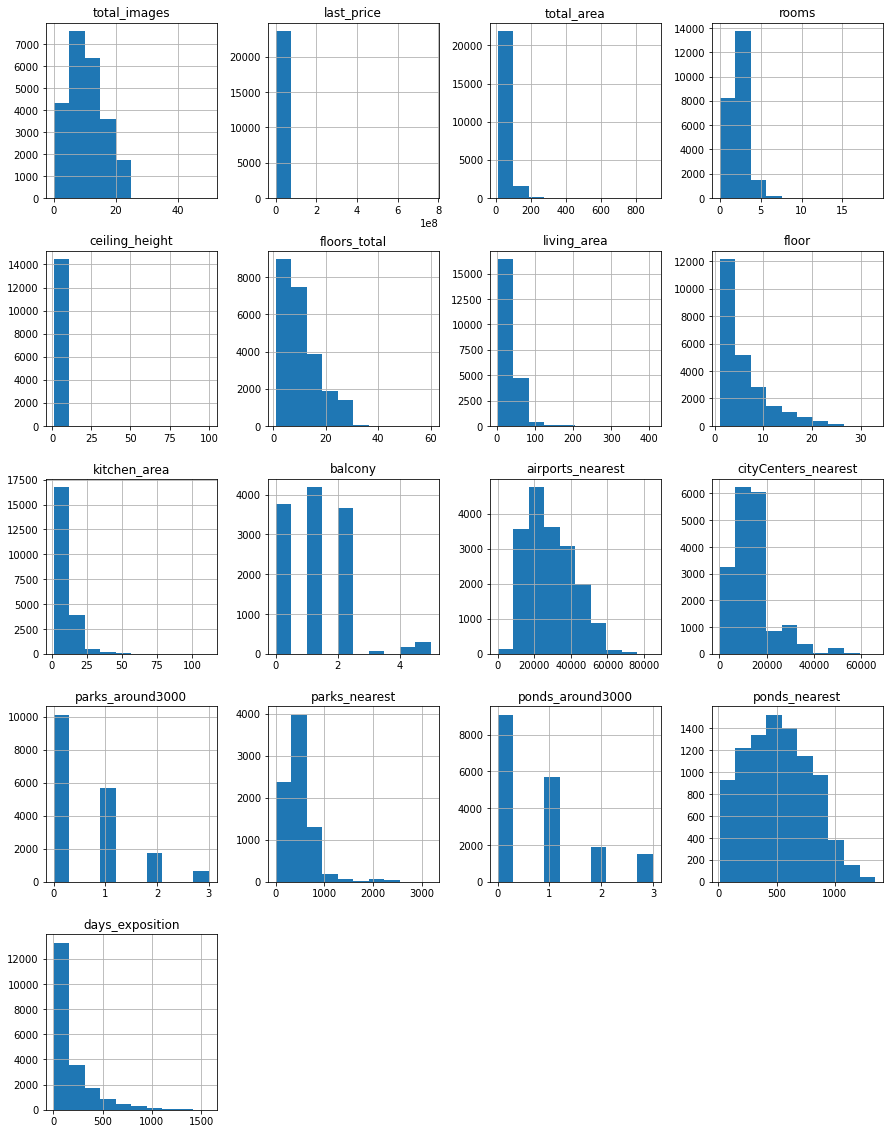

In [7]:
data.hist(figsize=(15, 20))
plt.show()

Для того, чтобы убрать предупреждения перед графиком, была импортирована библиотека `matplotlib.pyplot` и использована функция `show()`. 

In [8]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


## Предобработка данных

### Поиск и изучение пропущенных значений в столбцах

Определим в каких столбцах есть пропуски.

In [9]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

В столбцах `ceiling_height`, `floors_total `, `living_area`, `is_apartment`, `kitchen_area`, `balcony`, `locality_name`, `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest` и `days_exposition` есть пропущенные значения. Попробуем более деьтально разобрать пропуски.

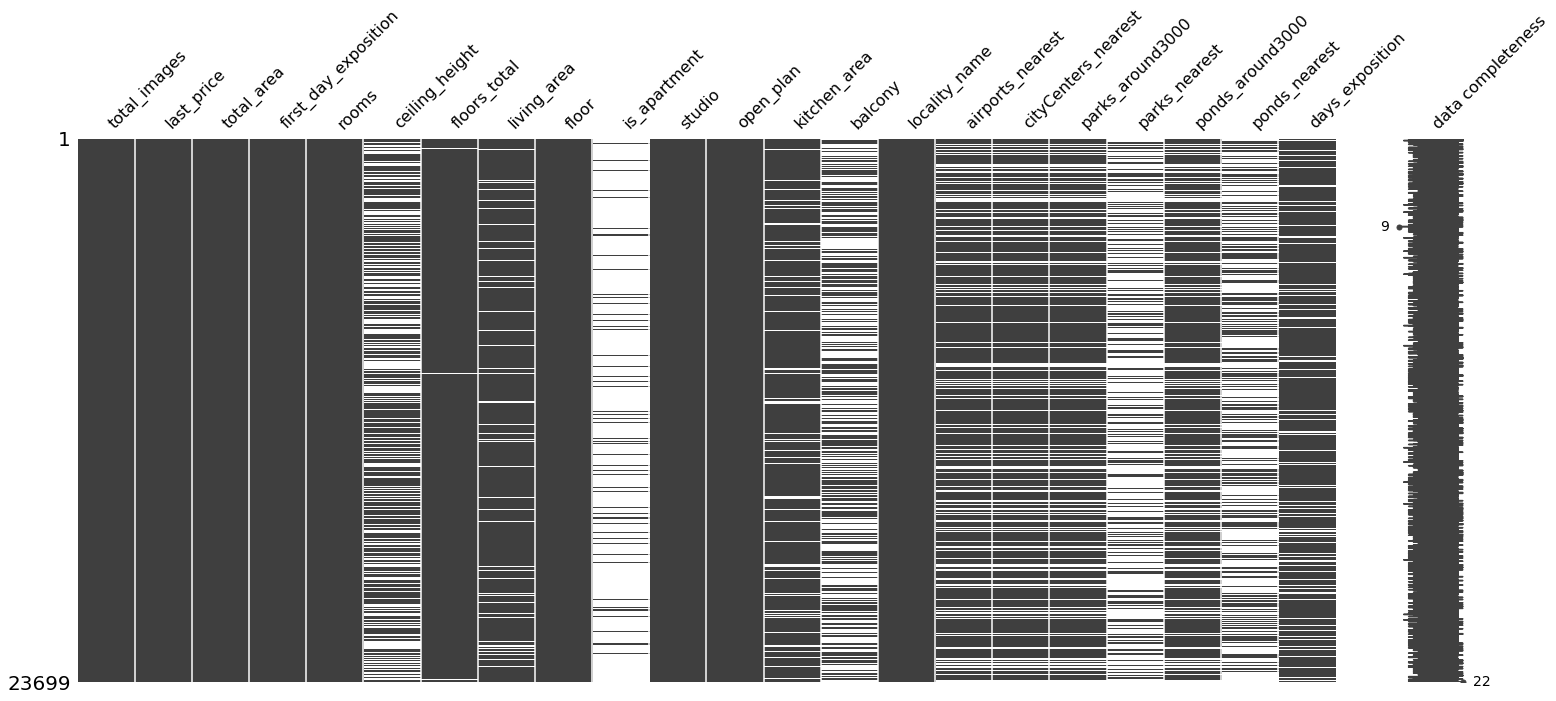

In [10]:
msno.matrix(data, labels=True)
plt.show()

Данный график наглядно показывает, в каких столбцах есть пропуски. Отлично видно отсутсвие данных с первого взгляда.

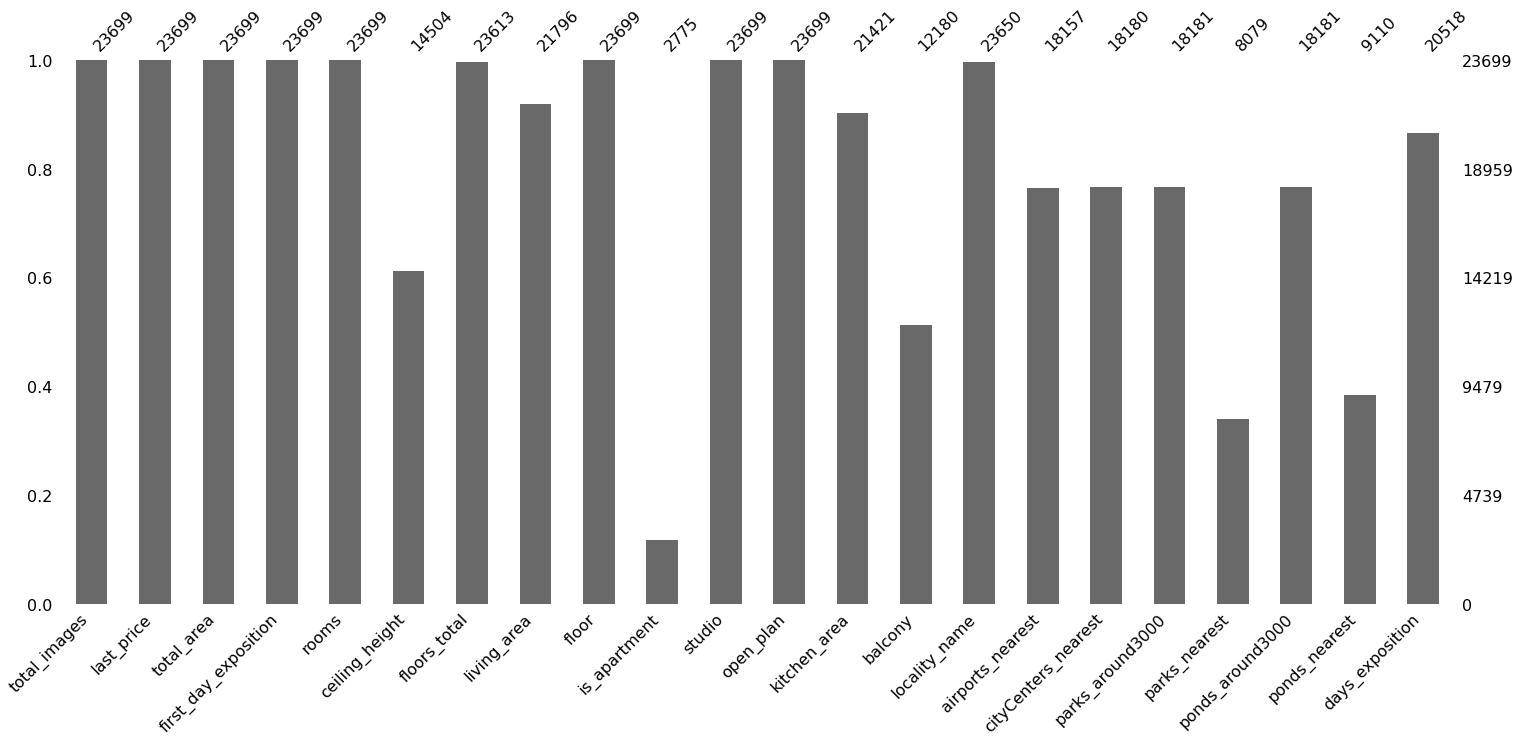

In [11]:
msno.bar(data)
plt.show()

Гистограмму можно использовать, чтобы более интуитивно увидеть соотношение и количество пропущенных переменных.

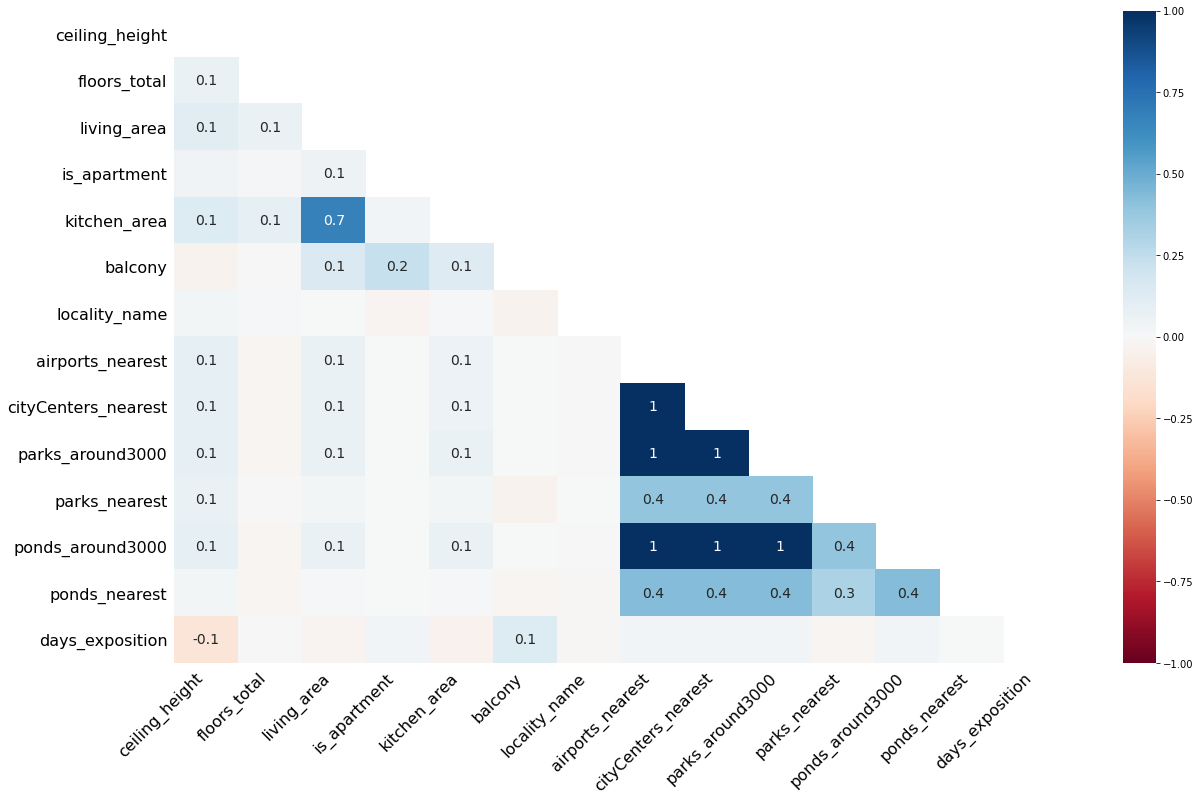

In [12]:
msno.heatmap(data)
plt.show()

График показывает насколько сильно присутствие или отсутствие одной переменной влияет на существование другой. Видно, что корреляция в столбце `ponds_around3000` между столбцами `airports_nearest`, `cityCenters_nearest` и `parks_around3000` равняется 1. Это значит, что пока удалены данные в одном столбце, они также будут отсутсвовать в другом.

Обрабатывать пропуски намного проще и нагляднее при использовании библиотеки `missingno`.

#### Заполнение пропущенных значений

Видим, что стобцов с пропусками больше половины. Попробуем разобраться, где можно заменить пропуски, где их лучше оставить или где удалить строки.

В столбце `ceiling_height` 9195 пропусков.
- Данный параметр указывает на высоту потолков и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Возможно, что пропуски появились из-за незнания высоты потолков в квартире;
- Мы пока не используем эти данные, нет необходимости заменять пропуски на медиану, это может испортить данные.

В столбце `floors_total` 86 пропусков. 
- Данный параметр указывает на количество этажей и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр пропустили случайно;
- В этом случае, пропущенные значения занимают меньше одного процента данных, поэтому их можно удалить.

In [13]:
data = data.dropna(subset=['floors_total']).reset_index(drop=True)

Проверим, сколько теперь пропусков в столбце `floors_total`.

In [14]:
data['floors_total'].isna().sum()

0

В столбце `living_area` 1903 пропусков.
- Данный параметр указывает на жилую площадь и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Возможно, что данный параметр не указали, т.к. не знают размеры именно жилой площади квартиры;
- Если заменить пропуски на медианные значения, то можно испортить данные;
- Думаю, что есть какая-то зависимость жилой площади, площади кухни и общей площади;
- Пока не работаем с этими данными их следует оставить в покое.

В столбце `is_apartment` 20838 пропусков.
- Данный параметр указывает на разновидность квартиры, является ли она апартаментами или нет;
- Думаю, большинство квартир не являются апартаментами, но в нашем случае лучше заменить пропуски в данной категории на `unknown`.

In [15]:
data['is_apartment'] = data['is_apartment'].fillna('unknown')

Проверим пропущенные значения в столбце `is_apartment`.

In [16]:
data['is_apartment'].isna().sum() 

0

В столбце `kitchen_area` 2231 пропусков.
- Это значение составляет около 10% от всего столбца данных;
- Данный параметр указывает на площадь кухни и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Возможно параметр не указали, т.к. не знают размеры площади кухни;
- Если заменить пропуски на медианные значения, то мы можем испортить данные;
- Также оставим данные, пока не работаем с ними.

В столбце `balcony` 11480 пропусков.
- Значение пропусков составляет около 50% от всего столбца данных;
- Данный параметр указывает на число балконов в квартире и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр пропустили, потому что балкона в квартире нет;
- Но не будем спешить с заменой, это также может повлиять на данные, т.к. процент пропусков очень большой.

В столбце `locality_name` 48 пропусков.
- Данный параметр указывает на название населенного пункта. 
- Скорее всего данный параметр пропустили случайно. 
- В этом случае, пропуски занимают меньше одного процента и можно их удалить, либо присвоить значение 'unknown'.

In [17]:
data = data.dropna(subset=['locality_name']).reset_index(drop=True)

Проверим количество пропусков в данном столбце.

In [18]:
data['locality_name'].isna().sum()

0

В столбце `airports_nearest` 5542 пропусков.
- Данный показатель составляет около 25% от всего столбца данных;
- Параметр указывает на расстояние до ближайшего аэропорта в метрах и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Возможно, что данный параметр не указали, т.к. не знают расстояние до аэропорта;
- Если заменить пропуски на медианные значения, то мы можем испортить данные;
- Думаю, что есть какая-то зависимость с другими данными;
- Пока не работаем с этими данными, их следует оставить в покое.

В столбце `cityCenters_nearest` 5519 пропусков.
- Пропуски составляют около 25% от всего столбца данных;
- Данный параметр указывает на расстояние  до центра города в метрах и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр не указали, т.к. не знают расстояние  до центра города, либо случайно пропустили;
- Если заменить сейчас на медианные значения, то мы можем испортить данные;
- Думаю, что есть какая-то зависимость с другими данными;
- Пока не работаем с этими данными, их следует оставить в покое.

В столбце `parks_around3000` 5518 пропусков.
- Пропуски составляют около 25% от всего столбца данных;
- Данный параметр указывает на число парков в радиусе 3 км и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Возможно данный параметр не указали, т.к. не знают число парков в радиусе 3 км, либо случайно пропустили его;
- Если заменить сейчас на медианные значения, то мы можем испортить данные.
- Думаю, что есть какая-то зависимость с другими данными.
- Пока не работаем с этими данными, их следует оставить в покое.

В столбце `parks_nearest` 15620 пропусков.
- Пропуски составляют около 70% от всего столбца данных;
- Данный параметр указывает на расстояние  до  до ближайшего парка в метрах и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр не указали, т.к. не знают расстояние  до ближайшего парка, либо случайно пропустили; 
- Если заменить сейчас на медианные значения, то мы можем испортить данные;
- Думаю, что есть какая-то зависимость с другими данными;
- Пока не работаем с этими данными, их следует оставить в покое.

В столбце `ponds_around3000` 5518 пропусков.
- Пропуски составляют около 25% от всего столбца данных;
- Данный параметр указывает на число водоёмов в радиусе 3 км и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр не указали, т.к. не знают число водоёмов в радиусе 3 км, либо случайно пропустили;
- Если заменить сейчас на медианные значения, то мы можем испортить данные;
- Думаю, что есть какая-то зависимость с другими данными;
- Пока не работаем с этими данными, их следует оставить в покое;
- Подозрительно, что в трех столбцах практически одинаковое количество пропусков, стоит проверить данные.

In [19]:
check_data = data.query('ponds_around3000.isna()') # проверка данных

In [20]:
check_data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,unknown,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,unknown,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,NaN,5.0,30.00,5,unknown,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.00,15,unknown,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,unknown,...,NaN,NaN,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23549,16,2100000.0,62.80,2018-09-18T00:00:00,4,2.50,5.0,45.50,3,unknown,...,5.50,NaN,посёлок Дзержинского,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23558,2,1350000.0,30.00,2017-07-07T00:00:00,1,NaN,5.0,17.50,4,unknown,...,6.00,NaN,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23561,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.00,4,unknown,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23562,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.70,1,unknown,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
check_data['parks_around3000'].isna().sum()

5500

In [22]:
check_data['cityCenters_nearest'].isna().sum()

5500

In [23]:
check_data['ponds_around3000'].isna().sum()

5500

После проверки можно убедиться, что эти данные отсутсвуют именно в тех местах, где отсутвуют данные по расстояниями и количеству парков и прудов. Вспомним, что данные столбца имеют корреляцию равную единице, что можно было увидеть на графиках в самом начале работы.

В столбце `ponds_nearest` 14589 пропусков.
- Пропуски имеют долю около 70% от всего столбца данных;
- Данный параметр указывает на расстояние до ближайшего водоема в метрах и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр не указали, т.к. не знают расстояние  до ближайшего парка, либо случайно пропустили;
- Если заменить сейчас на медианные значения, то мы можем испортить данные;
- Думаю, что есть какая-то зависимость с другими данными;
- Также как и в предыдущих случаях мы не работаем с этими данными, их следует оставить в покое.

В столбце `days_exposition` 3181 пропусков.
- Пропуски составляют около 20% от всего столбца данных.
- Данный параметр указывает на то, сколько дней было размещено объявление (от публикации до снятия) и имеет количественный характер, поэтому для устранения пропусков можно применить заполнение характерными значениями с использованием медианы;
- Скорее всего данный параметр не указали, т.к. кваритру не сняли с объявления, либо забыли, либо просто квартира все еще актуальна;
- Если заменить сейчас на медианные значения, то мы можем испортить данные.

Таким образом, мы посмотрели на различные столбцы и данные в них, где-то удалось заполнить пропуски, где-то нет, продолжим нашу предобработку данных. Далее рассмотрим типы данных в каждом столбце и при необходимости заменим пропуски в нужных столбцах.

### Типы данных

Посмотрим, какие столбцы имеют неправильный тип данных.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               12090 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

На первый взгляд неправильные типы даных могут быть в столбцах `first_day_exposition`, `floors_total`, `balcony` и `days_exposition`. Проверим это предположения.

In [25]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,unknown,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,unknown,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,unknown,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,unknown,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,unknown,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


В датафрейме в столбце `first_day_exposition` указан строковый тип данных. Посмотрев на столбец, можно сделать вывод, что в нем указаны даты. Для работы с датами, чтобы выполнять арифметические операции, переведем его в специальный тип данных - `datetime`.

In [26]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

Проверим, поменялось ли отображение даты в столбце и тип данных столбца.

In [27]:
data.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23560,9,9700000.0,133.81,2017-03-21,3,3.7,5.0,73.3,3,unknown,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23561,14,3100000.0,59.00,2018-01-15,3,NaN,5.0,38.0,4,unknown,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23562,18,2500000.0,56.70,2018-02-11,2,NaN,3.0,29.7,1,unknown,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23563,13,11475000.0,76.75,2017-03-28,2,3.0,17.0,NaN,12,unknown,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23564,4,1350000.0,32.30,2017-07-21,1,2.5,5.0,12.3,1,unknown,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  float64       
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

В столбце `floors_total` указано количество этажей в доме. В датафрейме стоит тип данных для вещественных показателей. В данном случае нам нужен тип целый тип данных, т.к. не может быть 3.4 этажа в доме.

Для экономии вычислительной памяти, можем перевести в тип данных `int32`.

In [29]:
data['floors_total'] = data['floors_total'].astype('int32')

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

В столбце `balcony` также указан тип данных `float`, но количество балконов не может быть вещественным числом. Поэтому поменяем тип данных на целочисленный. Для начала следует заменить, чтобы данным можно было поменять тип. В домах обычно нет балконов только на первом этаже, можно посмотреть на количество первых этажей и понять правдоподобны ли данные, если да, то заменим пропуски в стобце на медианное значение. Также актуален вариант с заполнением пропущенных значений на 0.

In [31]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [32]:
data['floor'].value_counts()

2     3351
3     3061
1     2909
4     2793
5     2612
6     1293
7     1211
8     1075
9     1045
10     684
11     520
12     519
13     376
15     340
14     333
16     315
17     226
18     175
19     144
21     119
22     111
20     108
23      98
24      61
25      46
26      24
27      10
28       1
29       1
32       1
30       1
33       1
31       1
Name: floor, dtype: int64

In [33]:
data['balcony'].value_counts()

1.0    4187
0.0    3680
2.0    3656
5.0     304
4.0     182
3.0      81
Name: balcony, dtype: int64

In [34]:
balcon = data['balcony'].median()

In [35]:
data['balcony'] = data['balcony'].fillna(balcon).astype('int16')

In [36]:
data['balcony'].isna().sum()

0

Проверим тип данных столбца `balcony`.

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

В столбце `days_exposition` требуется обработать пропущенные значения, а затем изменить тип данных на `int`. Заменим пропуски на маркер `-1`.

In [38]:
data['days_exposition'] = data['days_exposition'].fillna(-1).astype('int')

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23565 entries, 0 to 23564
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

### Изучение дубликатов

Изучим уникальные значения в столбце с названиями и устраним неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Можно заменить названия в существующем столбце или создать новый с названиями без дубликатов.

In [40]:
data.duplicated().sum()

0

Явные дубликаты отсутсвуют в нашем датафрейме. Попробуем найти неявные дубликаты.

In [41]:
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [42]:
data['locality_name'].sort_values().nunique()

364

Видим, что в данных есть 364 уникальных значения, постараемся уменьшить это число т.к. с первого взгляда видно, что есть повторяющиеся названия. Первым делом заменим слово `поселок` на  `посёлок` и заменим несколько значений, которые сразу бросились в глаза.

In [43]:
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')

In [44]:
data['locality_name'].sort_values().nunique()

330

In [45]:
data['locality_name'] = data['locality_name'].str.replace('посёлок Мурино','Мурино')

In [46]:
data['locality_name'].sort_values().nunique()

329

In [47]:
data['locality_name'] = data['locality_name'].str.replace('деревня Кудрово','Кудрово')

In [48]:
data['locality_name'].sort_values().nunique()

328

Видим, что количество названий сократилось.

Создадим функцию, которая отбирает название населенного пункта по заглавной букве.

In [49]:
def extract_capital(text):
    capwords = [s for s in text.split(" ") if s.istitle()]
    return " ".join(capwords) 


In [50]:
data['locality_name'] = data['locality_name'].apply(extract_capital)

In [51]:
data['locality_name'].sort_values().nunique()

305

При изучении дубликатов было выявлено, что есть повторяющиеся населенные пункты с разными приставками к их названиям, например: поселок Мурино, поселок городского типа Мурино и Мурино. 

В данном столбце сложно определить все неявные дубликаты и долго перебирать каждый населенный пункт, заменяя неявный дубликат. Поэтому принято решение отбросить все обозначения населенных пунктов и оставить только их названия с помощью функции `extract_capital`.

Данным способом можно было сразу выявить 59 неявных дубликата.

### Поиск и устранение аномальных значений

Посмотрим на столбец `ceiling_height`, в котором хранятся данные о высоте потолка.

In [52]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [53]:
data['ceiling_height'].isna().sum()

9084

Для работы с данным необходимо разобраться с пропусками. В данном случае можно попробовать заполнить пропуски мединным значением по высоте дома.

In [54]:
data.groupby('floors_total')['ceiling_height'].agg('median')

floors_total
1      2.80
2      2.70
3      2.80
4      3.00
5      2.55
6      3.00
7      3.00
8      2.80
9      2.55
10     2.60
11     2.75
12     2.65
13     2.70
14     2.60
15     2.70
16     2.70
17     2.70
18     2.70
19     2.75
20     2.75
21     2.70
22     2.75
23     2.75
24     2.75
25     2.75
26     2.66
27     2.70
28     2.60
29     2.60
33      NaN
34     2.65
35     2.70
36    14.85
37     1.75
52     2.65
60     2.88
Name: ceiling_height, dtype: float64

Исключим данные, которые находятся в домах с высотой 33 этажа, т.к. это единичный случай и данных о потолках там нет.

In [55]:
data = data[data['floors_total'] != 33]

In [56]:
for index in data['floors_total'].unique():
    data.loc[(data['floors_total'] == index) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['floors_total'] == index), 'ceiling_height'].median()

In [57]:
data['ceiling_height'].isna().sum()

0

Проверив данные на пропуски, мы можем приступать к изчению аномалий. Видно, что в данных есть значения, которые больше 20 метров. Такого быть не может, возможно, кто-то ошибся, когда вводил данные, поэтому разделим их на 10 и получим правдоподобный вариант. Будем использовать функцию `norm_height`.

In [58]:
def norm_height(height):
    if height >= 20:
        return height/10
    return height

In [59]:
data['ceiling_height'] = data['ceiling_height'].apply(norm_height)

In [60]:
data['ceiling_height'].sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.26,  2.3 ,  2.34,
        2.4 ,  2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,
        2.53,  2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,
        2.62,  2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,
        2.71,  2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,
        2.8 ,  2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,
        2.89,  2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,
        2.98,  2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,
        3.07,  3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,
        3.16,  3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,
        3.26,  3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,
        3.35,  3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,
        3.45,  3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,
        3.54,  3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,
        3.65,  3.66,

Следующим шагом посмотрим соотношение слишком низких потолков и слишком высоких. Определим для них промежуток от 2.4 м до 4.2 м. Если данных, которые находятся за пределами данного промежутка не так много, то устраним их.

In [61]:
data['ceiling_height'][data['ceiling_height'] > 4.2 ].value_counts().sum()

36

In [62]:
data['ceiling_height'][data['ceiling_height'] < 2.4].value_counts().sum()

23

In [63]:
data = data.query('2.4 <= ceiling_height <= 4.2 ').copy()

In [64]:
data['ceiling_height'].sort_values().unique()

array([2.4 , 2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54,
       2.55, 2.56, 2.57, 2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65,
       2.66, 2.67, 2.68, 2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76,
       2.77, 2.78, 2.79, 2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87,
       2.88, 2.89, 2.9 , 2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98,
       2.99, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09,
       3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2 , 3.21,
       3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32,
       3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4 , 3.42, 3.43, 3.44,
       3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54, 3.55,
       3.56, 3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65, 3.66, 3.67, 3.68,
       3.69, 3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84, 3.85, 3.86,
       3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 , 4.14, 4.15,
       4.19, 4.2 ])

Теперь данные более правдоподобны. Посмотрим на столбцы `balcony` и `rooms`.

In [65]:
data['rooms'].value_counts()

1     7988
2     7881
3     5765
4     1170
5      319
0      193
6      101
7       57
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

В столбце `rooms` есть аномальные значения, такие как 0 комнат или больше 8 комнат. Эти данные можно удалить.

In [66]:
data = data.query('1 <= rooms <= 7').copy()

In [67]:
data.shape

(23281, 22)

Посмотрим на распределение балконов по комнатам.

In [68]:
data['balcony'].value_counts()

1    15500
0     3652
2     3564
5      302
4      182
3       81
Name: balcony, dtype: int64

In [69]:
data.groupby('rooms')['balcony'].value_counts()

rooms  balcony
1      1          5252
       2          1482
       0          1212
       5            24
       4            16
       3             2
2      1          5336
       0          1237
       2          1143
       5            83
       4            61
       3            21
3      1          3755
       0           894
       2           828
       5           165
       4            82
       3            41
4      1           806
       0           220
       2            91
       5            23
       4            18
       3            12
5      1           228
       0            62
       2            15
       4             5
       5             5
       3             4
6      1            82
       0            15
       2             4
7      1            41
       0            12
       5             2
       2             1
       3             1
Name: balcony, dtype: int64

Видно, что в однокомнатных квартираз могут встретиться пять балконов, такое врядли возможно. Поэтому разобьем квартиры на категории по количеству квадратных метров.

- В категории "А" будут квартиры до 40 кв.м.;
- В категории "B" будут квартиры от 41 до 60 кв.м.;
- В категории "С" будут квартиры от 61 до 80 кв.м.;
- В категории "D" будут квартиры от 81 до 100 кв.м;
- В категории "E" будут квартиры выше 101 кв. м.

Будем считать, что любая квартира может либо иметь один балкон, либо не иметь балкон. Два балкона могут быть в квартирах размерами более чем 31 кв.м., минимальная категория "В". Три балкона, могут быть начиная с категории "С". Четыре балкона могут быть в квартирах в категории "D" и выше. Пять балконов могут быть только в категории "Е". Остальные данные будут считаться выбросами.

In [70]:
def categorize_area(area):
    try:
        if area <= 30:
            return 'A'
        elif 31 <= area <= 50:
            return 'B'
        elif 51 <= area <= 80:
            return 'C'
        elif 81 <= area <= 100:
            return 'D'
        elif area >= 101:
            return 'E'
    except:
        pass

In [71]:
data['total_area_category'] = data['total_area'].apply(categorize_area)

In [72]:
data.groupby('total_area_category')['balcony'].value_counts()

total_area_category  balcony
A                    1           516
                     0           143
                     2            60
B                    1          6795
                     2          1590
                     0          1561
                     4            30
                     5            20
                     3             4
C                    1          5406
                     2          1494
                     0          1290
                     5           162
                     4            71
                     3            43
D                    1          1173
                     0           282
                     2           236
                     5            68
                     4            41
                     3            13
E                    1          1199
                     0           298
                     2           139
                     5            46
                     4            36
         

In [73]:
data = data.loc[((data['total_area_category'] == 'A')&(data['balcony'] <= 1))
              |((data['total_area_category'] == 'B')&(data['balcony'] <= 2))
              |((data['total_area_category'] == 'C')&(data['balcony'] <= 3))
              |((data['total_area_category'] == 'D')&(data['balcony'] <= 4))
              |(data['total_area_category'] == 'E')]

In [74]:
data.shape

(22320, 23)

Таким образом, мы исключили аномалии в количестве балконов в квартирах, пришлось исключить около четырех процентов данных. Но в данном случае они бы исказили всю ситуации, т.к. это выбросы.

Посмотрим на то, как распределена цена квартир.

In [75]:
data['last_price'].sort_values()

8750         12190.0
14825       430000.0
16185       440000.0
9535        450000.0
17577       450000.0
            ...     
22701    289238400.0
15565    300000000.0
1431     330000000.0
14621    401300000.0
12897    763000000.0
Name: last_price, Length: 22320, dtype: float64

Сразу можно заметить, что есть один выброс. Квартира не может стоить 12190. Установим нижнюю границу в 400000, тем самым отфлитруем данное значение.

In [76]:
data = data[data['last_price'] > 400000]

In [77]:
data.shape

(22319, 23)

После изучения аномалий, количество данных уменьшилось, но не сильно. Поэтому можно сделать вывод, что данные не исказились.

## Посчитать и добавить в таблицу новые столбцы

### Цена одного квадратного метра

In [78]:
data['price_meter'] = data['last_price'] / data['total_area']

### День недели публикации объявления

In [79]:
data['week_day'] = data['first_day_exposition'].dt.weekday 

### Месяц публикации объявления

In [80]:
data['month_day'] = pd.DatetimeIndex(data['first_day_exposition']).month

### Год публикации объявления

In [81]:
data['year_publication'] = pd.DatetimeIndex(data['first_day_exposition']).year

### Тип этажа квартиры

Создадим функцию `type_floor`, которая будет распределять этажи по разным категориям.

In [82]:
def type_floor(rec):
    if rec["floor"] == 1:
        return "первый"
    elif rec["floor"] == rec["floors_total"]:
        return "последний"
    return "другой"

In [83]:
data['type_floor'] = data.apply(type_floor, axis=1)

### Расстояние до центра города в километрах

Для начала заменим пропущенные значения в столбце `cityCenters_nearest`. Поменяем пропуски на маркер значение `-1`.

In [84]:
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(-1)

In [85]:
data['cityCenters_km'] = (data['cityCenters_nearest']/1000).round()

Проверяем наличие всех новых столбцов.

In [86]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,total_area_category,price_meter,week_day,month_day,year_publication,type_floor,cityCenters_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,unknown,...,2.0,755.0,-1,E,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.75,11,18.6,1,unknown,...,0.0,NaN,81,B,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.55,5,34.3,4,unknown,...,2.0,574.0,558,C,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.60,14,NaN,9,unknown,...,3.0,234.0,424,E,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,unknown,...,1.0,48.0,121,D,100000.000000,1,6,2018,другой,8.0


Все на месте, теперь мы можем перейти к исследовательскому анализу.

## Проведём исследовательский анализ данных

### Изучение параметров объектов

Для изучения параметров объектов создадим функцию `box_mustache`, которая будет возвращать минимальное значение ящика с усами и максимальное, после которого идут выбросы. Расчитаем интерквартильный размах, а затем прибавим 1,5 интерквартильного размаха к значению 75% и убавим от 25% выборки.

In [87]:
def box_mustache(data):
    iqr = data.describe().loc['75%'] -  data.describe().loc['25%']
    maximum = data.describe().loc['75%'] + (1.5 * iqr)
    minimum = data.describe().loc['25%'] - (1.5 * iqr)
    if minimum <= 0:
        print(f'Максимальное значение усов, после которого идут выбросы: {round(maximum)}.')
    else:
        print(f'Максимальное значение усов, после которого идут выбросы: {round(maximum)}.')
        print(f'Минимальное значение усов, после которого идут выбросы: {min(data)}.')

#### Исследование общей площади

In [88]:
data['total_area'].describe()

count    22319.000000
mean        60.391101
std         34.002162
min         12.000000
25%         40.400000
50%         52.200000
75%         69.745000
max        631.200000
Name: total_area, dtype: float64

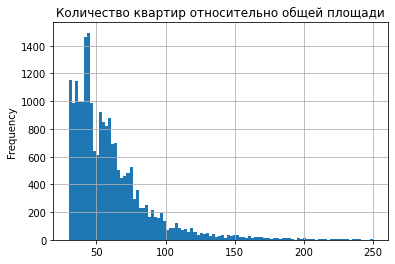

In [89]:
data['total_area'].plot(kind ='hist', bins=100, grid=True, range=(30,250),
                        title='Количество квартир относительно общей площади')
plt.show()

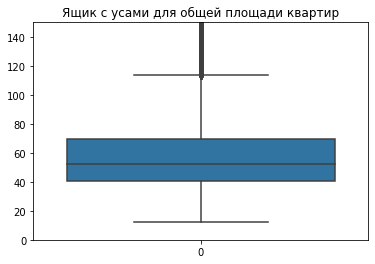

In [90]:
sns.boxplot(data=data['total_area'])
plt.ylim(0,150)
plt.title('Ящик с усами для общей площади квартир')
plt.show()

In [91]:
box_mustache(data['total_area']);

Максимальное значение усов, после которого идут выбросы: 114.


Исходя из анализа, можно сделать следующие выводы:

- в среднем общая площадь квартиры 60 кв. м.;
- медианное значение 52 кв. м.;
- максимальная площадь 631 кв.м.;
- минимальная площадь 12 кв. м.

По гистограмме видно, что после 100 кв.м. очень мало квартир. Пик количества квартир находится около 50 кв.м. Также стоит отметить, что можно считать выбросами значения, которые выше 114 кв.м., потому что они находятся за усами графика.

#### Исследование жилой площади

In [92]:
data_living_area = data['living_area'].dropna()

In [93]:
data_living_area.describe()

count    20523.000000
mean        34.425900
std         21.054334
min          2.000000
25%         18.800000
50%         30.000000
75%         42.400000
max        332.000000
Name: living_area, dtype: float64

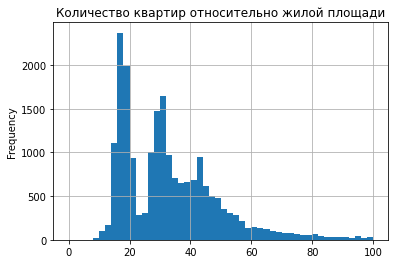

In [94]:
data_living_area.plot(kind ='hist',bins=50, grid=True, range=(0,100), 
                         title='Количество квартир относительно жилой площади')
plt.show()

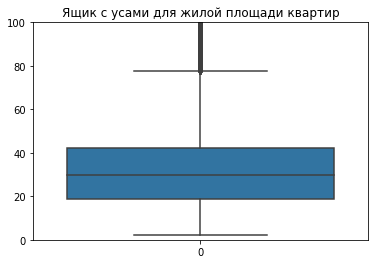

In [95]:
sns.boxplot(data=data_living_area)
plt.ylim(0,100)
plt.title('Ящик с усами для жилой площади квартир')
plt.show()

In [96]:
box_mustache(data_living_area);

Максимальное значение усов, после которого идут выбросы: 78.


Исходя из анализа в столбце `living_area`, можно сделать следующие выводы:

- среднее значение 34 кв. м.;
- медианное значение 30 кв. м.;
- минимальное значение 2 кв. м.;
- максимальная 332 кв. м.

По графику видно, что распределение имеет два пика, что не является нормальным. С 20 до 25 квадратных метров находится некий провал в данных. Затем опять идет рост количества квартир с более высокой жилой площадью. После 78 кв.м. жилой площади идет очень мало значений, можно считать их выбросами, т.к. они находятся за пределами ящика с усами.

#### Исследование площади кухни

In [97]:
data_kitchen_area = data['kitchen_area'].dropna()

In [98]:
data_kitchen_area.describe()

count    20366.000000
mean        10.573626
std          5.822741
min          1.300000
25%          7.000000
50%          9.200000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

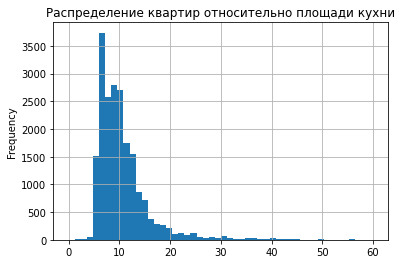

In [99]:
data_kitchen_area.plot(kind ='hist', bins=50, grid=True, range=(0,60),
                          title='Распределение квартир относительно площади кухни')
plt.show()

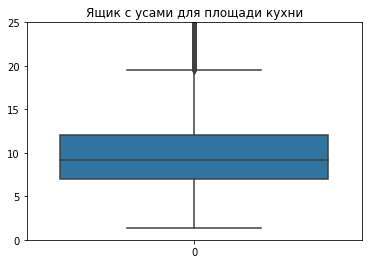

In [100]:
sns.boxplot(data=data_kitchen_area)
plt.ylim(0,25)
plt.title('Ящик с усами для площади кухни')
plt.show()

In [101]:
box_mustache(data_kitchen_area);

Максимальное значение усов, после которого идут выбросы: 20.


В столбце `kitchen_area` было определено, что:

- среднее значение 10.5 кв. м.;
- медианное значение 9.1 кв. м.;
- площадь кухни имеет минимальное значение 1.3 кв. м.;
- максимальное 107 кв. м.

По графику видно, что распределение имеет пиковое значение до 10 кв.м. Значения после 20 кв. м. будем считать выбросами, потому что они находятся за пределами ящика с усами.

#### Исследование цены объекта

In [102]:
data['last_price'].describe()

count    2.231900e+04
mean     6.515152e+06
std      1.048034e+07
min      4.300000e+05
25%      3.470000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

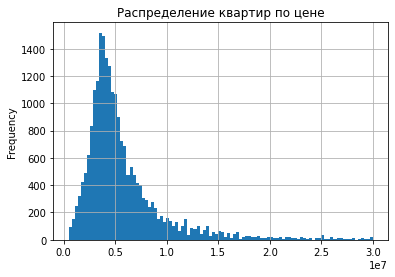

In [103]:
data['last_price'].plot(kind ='hist', bins=100, grid=True, range=(5e+05, 3e+07),
                        title='Распределение квартир по цене')
plt.show()

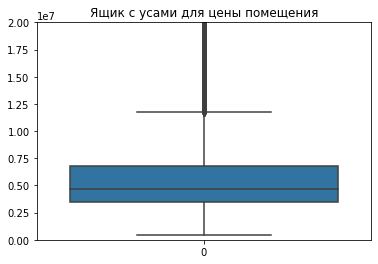

In [104]:
sns.boxplot(data=data['last_price'])
plt.ylim(0, 0.2e+08)
plt.title('Ящик с усами для цены помещения')
plt.show()

In [105]:
box_mustache(data['last_price']);

Максимальное значение усов, после которого идут выбросы: 11795000.


В столбце `last_price` было проведено исследование и выявлено, что:

- среднее значение стоимости 6.4 млн.;
- медианное значение 4.65 млн.;
- минимальное значение 430 тыс.;
- максимальное значение 763 млн.

По графику видно, что пиковое значение приходится на 3.5 - 4 млн. В данном случае значения, которые лежат за пределами ящика с усами, можно считать выбросами. Данные значения начинаются с 11.795 млн. и выше.

#### Исследование количества комнат 

In [106]:
data['rooms'].describe()

count    22319.00000
mean         2.08159
std          1.02545
min          1.00000
25%          1.00000
50%          2.00000
75%          3.00000
max          7.00000
Name: rooms, dtype: float64

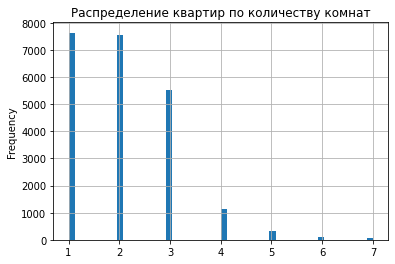

In [107]:
data['rooms'].plot(kind ='hist', bins=50, grid=True, title='Распределение квартир по количеству комнат')
plt.show()

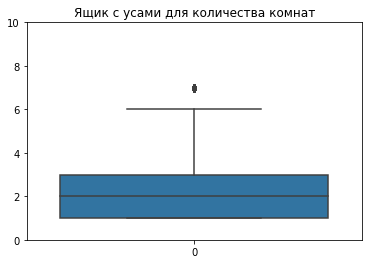

In [108]:
sns.boxplot(data=data['rooms'])
plt.ylim(0, 10)
plt.title('Ящик с усами для количества комнат')
plt.show()

In [109]:
box_mustache(data['rooms']);

Максимальное значение усов, после которого идут выбросы: 6.


В столбце `rooms` было выявлено, что:

- среднее значение количества комнат равняется 2;
- медианное значение показывает такое же как и среднее;
- максимальное значение 7 комнат;
- минимальное 1 комната.

Видно, что распределение происходит так, что чем больше комнат, тем меньше количество таких квартир. Можно считать выбросами значения, которые не входят в ящик с усами, в нашем случае это количество комнат равное 7.

#### Исследование высоты потолков

In [110]:
data['ceiling_height'].describe()

count    22319.000000
mean         2.706735
std          0.224167
min          2.400000
25%          2.550000
50%          2.650000
75%          2.750000
max          4.200000
Name: ceiling_height, dtype: float64

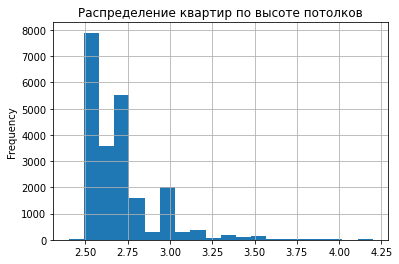

In [111]:
data['ceiling_height'].plot(kind ='hist', bins=20, grid=True, title='Распределение квартир по высоте потолков')
plt.show()

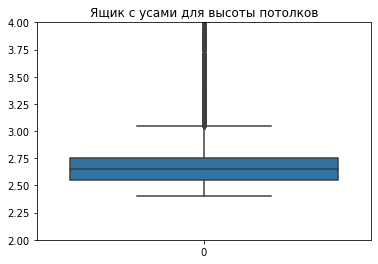

In [112]:
sns.boxplot(data=data['ceiling_height'])
plt.ylim(2, 4)
plt.title('Ящик с усами для высоты потолков')
plt.show()

In [113]:
box_mustache(data['ceiling_height']);

Максимальное значение усов, после которого идут выбросы: 3.
Минимальное значение усов, после которого идут выбросы: 2.4.


В столбце `ceiling_height` после исследования было выявлено, что:

- среднее значение 2.7 м.;
- медианное очень близко к среднему и составляет 2.65 м.;
- минимальное значение 2.4 м.;
- максимальное 4.2 м.

Видно, что распределение происходит так, что основная масса квартир имеет высоту потолков от 2.5 до 2.75 м. По расчетам, можно сделать вывод, что высота потолков больше 3х метров может считаться аномальной, т.к. выходит за пределы ящика с усами.

#### Исследование этажей квартир

In [114]:
data['floor'].describe()

count    22319.000000
mean         5.846364
std          4.849774
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

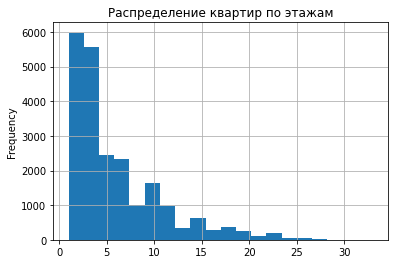

In [115]:
data['floor'].plot(kind ='hist', bins=20, grid=True, title='Распределение квартир по этажам')
plt.show()

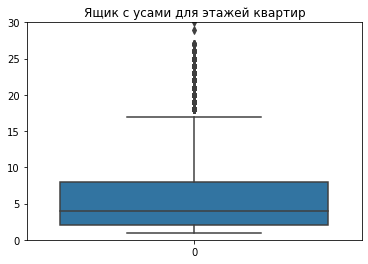

In [116]:
sns.boxplot(data=data['floor'])
plt.ylim(0, 30)
plt.title('Ящик с усами для этажей квартир')
plt.show()

In [117]:
box_mustache(data['floor']);

Максимальное значение усов, после которого идут выбросы: 17.


Исследовав столбец `floor` можно сделать выводы, что:

- среднее значение данного столбца 6 этаж;
- медианное значение 4 этаж;
- минимальное значение 1 этаж;
- максимальное значение 33 этаж.
 
Наибольшее количество домов находятся как раз в пределах пятиэтажных домов. В данном случае значения выше 17 этажей можно считать выбросами, т.к. они не входят в ящик с усами.

#### Исследование типов этажей квартир

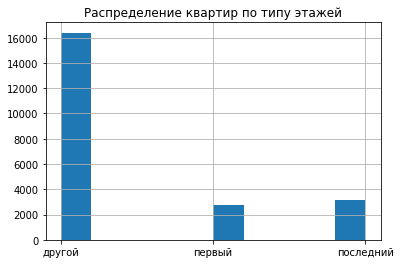

In [118]:
data['type_floor'].hist()
plt.title('Распределение квартир по типу этажей')
plt.show()

Исследовав столбец `type_floor`, можно сделать некоторые выводы:

- по гистограмме видно, что квартир на первом этаже меньше всего;
- на последнем этаже чуть больше;
- самое большое количество квартир, очевидно, занимает категория "другой этаж".

#### Исследование общего количества этажей в домах

In [119]:
data['floors_total'].describe()

count    22319.00000
mean        10.63139
std          6.57296
min          1.00000
25%          5.00000
50%          9.00000
75%         16.00000
max         60.00000
Name: floors_total, dtype: float64

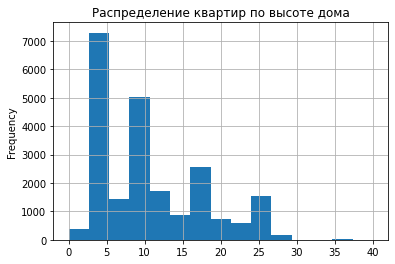

In [120]:
data['floors_total'].plot(kind ='hist', bins=15, range=(0,40), grid=True,
                          title='Распределение квартир по высоте дома')
plt.show()

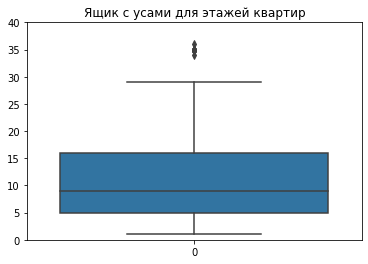

In [121]:
sns.boxplot(data=data['floors_total'])
plt.ylim(0, 40)
plt.title('Ящик с усами для этажей квартир')
plt.show()

In [122]:
box_mustache(data['floors_total']);

Максимальное значение усов, после которого идут выбросы: 32.


После исследования столбца `floors_total`, можно сделать некоторые выводы:

- медианное значение равняется 9 этажам;
- среднее в свою очередь 10 этажам;
- максимальное количество этажей 60;
- минимальное количество этажей в доме равняется 1.

Распределение имеет некоторые взлеты и провалы. В данном случае можем считать, что значения выше 32 этажей это выбросы.

#### Исследование расстояния до центра города в метрах

В столбце находятся данные, которые были пропущены, это могла быть техническая ошибка или просто случайность. Мы заменили данные значения на -1 и таких значений около 20 процентов. Исключим их из выборки и построим гистограмму.

In [123]:
city_center = data.query('cityCenters_nearest > 0').copy()

In [124]:
city_center['cityCenters_nearest'].describe()

count    17131.000000
mean     14166.451579
std       8629.064676
min        181.000000
25%       9148.000000
50%      13073.000000
75%      16277.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

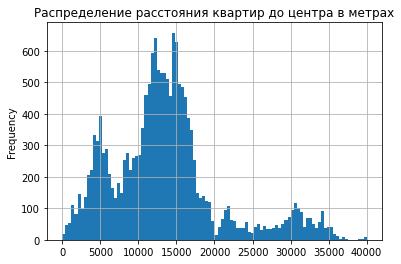

In [125]:
city_center['cityCenters_nearest'].plot(kind ='hist', bins=100, range=(0,40000), grid=True,
                                 title='Распределение расстояния квартир до центра в метрах')
plt.show()

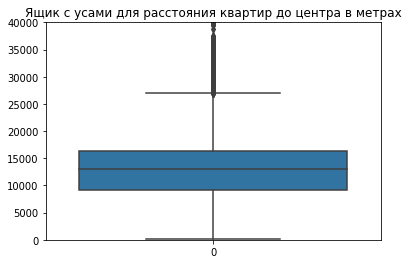

In [126]:
sns.boxplot(data=city_center['cityCenters_nearest'])
plt.ylim(0, 40000)
plt.title('Ящик с усами для расстояния квартир до центра в метрах')
plt.show()

In [127]:
box_mustache(city_center['cityCenters_nearest']);

Максимальное значение усов, после которого идут выбросы: 26972.


Исследовав столбец `cityCenters_nearest`, можно сделать некоторые выводы:

- среднее значение состовляет 14221 метр;
- медианное 13107 метров;
- максимальное значение 65968 метров, что слишком далеко от центра города;
- минимальное 181 метр, по сути и есть центр.

Пик значений приходится на 10000-15000 метров до центра города. В данном случае, можно считать выбросами значения выше 26972 метров, т.к. они не входят в ящик с усами.

#### Изучение расстояния до ближайшего аэропорта

In [128]:
data['airports_nearest'] = data['airports_nearest'].fillna(-1)

In [129]:
data_airports = data.query('airports_nearest > 0').copy()

В этом столбце мы также заменили значения на `-1` и отфильтровали для построения диаграммы и анализа данных пустые значения.

In [130]:
data_airports['airports_nearest'].describe()

count    17110.000000
mean     28837.789655
std      12618.266633
min       6450.000000
25%      18625.000000
50%      26770.500000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

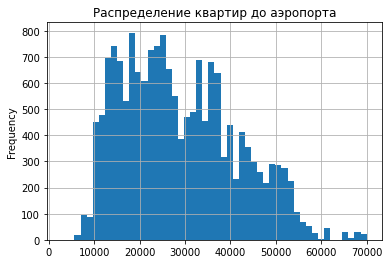

In [131]:
data_airports['airports_nearest'].plot(kind ='hist', bins=50, range=(3000,70000), grid=True,
                              title='Распределение квартир до аэропорта')
plt.show()

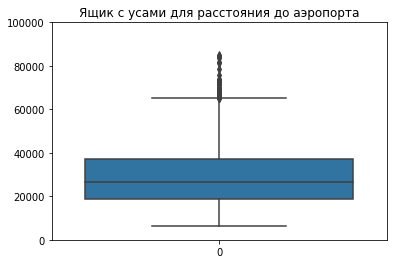

In [132]:
sns.boxplot(data=data_airports['airports_nearest'])
plt.ylim(0, 100000)
plt.title('Ящик с усами для расстояния до аэропорта')
plt.show()

In [133]:
box_mustache(data_airports['airports_nearest']);

Максимальное значение усов, после которого идут выбросы: 65245.


После исследования столбца `airports_nearest` можно сказать, что:

- среднее значение раастояния до аэропорта составляет 28838 метров;
- медианное значение 26798 метров;
- минимальное значение около 6 км;
- максимальное около 85км.

В целом на гистограмме видно, что равномерное распределение от 10000 до 40000 метров. Можно сказать, что значения, которые находятся за 65245 м. выбросы.

#### Исследование расстояния до ближайшего парка

Как и в предыдущих двух столбцах, здесь необходимо заменить пропуски и отфильтровать данные.

In [134]:
data['parks_nearest'] = data['parks_nearest'].fillna(-1)

In [135]:
data['parks_nearest'].isna().sum()

0

In [136]:
data_parks = data.query('parks_nearest > 0').copy()

In [137]:
data_parks['parks_nearest'].describe()

count    7625.000000
mean      490.607344
std       341.919630
min         1.000000
25%       288.000000
50%       453.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

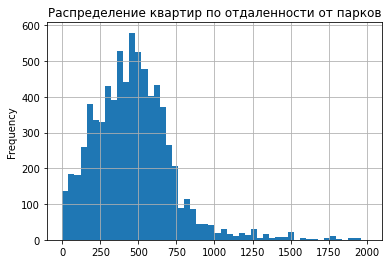

In [138]:
data_parks['parks_nearest'].plot(kind ='hist', bins=50, range=(0,2000), grid=True,
                              title='Распределение квартир по отдаленности от парков')
plt.show()

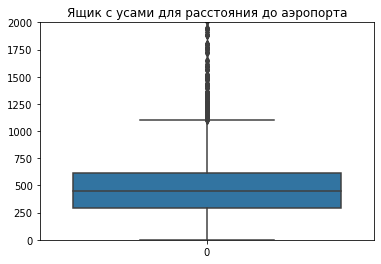

In [139]:
sns.boxplot(data=data_parks['parks_nearest'])
plt.ylim(0, 2000)
plt.title('Ящик с усами для расстояния до аэропорта')
plt.show()

In [140]:
box_mustache(data_parks['parks_nearest']);

Максимальное значение усов, после которого идут выбросы: 1098.


После исследования  столбца `parks_nearest`, можно сделать выводы:

- среднее значение расстояния до парка, является 490 метров;
- медианное значение равно 453 метра;
- максимальное расстояние 3 км.;
- минимальное 1 метр, что маловероятно.

Пик приходится на 400-500 метров. Видно, что в данном случе, максимальное значение усов, после которого идут выбросы равняется 1098 метров.

#### Исследование дня и месяца публикации объявления

In [141]:
data['week_day'].describe()

count    22319.000000
mean         2.569425
std          1.787383
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: week_day, dtype: float64

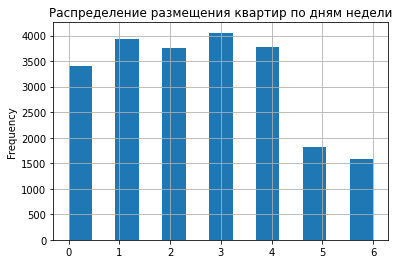

In [142]:
data['week_day'].plot(kind ='hist', bins=13, grid=True,
                              title='Распределение размещения квартир по дням недели')
plt.show()

По гистограмме видно, что в субботу и в воскресенье есть спад размещения предложений. Скорее всего, из-за того, что все хотят отдыхать. Максимальные значения можно увидеть во вторник и в четверг. Выходные являются причиной просадки количества объявлений.

In [143]:
data['month_day'].describe()

count    22319.000000
mean         6.401810
std          3.492189
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_day, dtype: float64

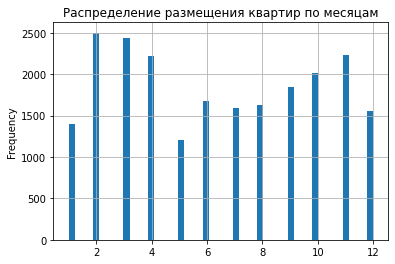

In [144]:
data['month_day'].plot(kind ='hist', bins=50, grid=True,
                              title='Распределение размещения квартир по месяцам')
plt.show()

На графике видно, что в декабре и январе явный спад размещения объявлений, как и летом, а вот весной сильный прирост в объявлениях. Осенью, после летних отпусков, тоже идет рост размещения объявлений. Можно заметить, что Месяца с наибольшим количеством выходных тоже выделяются тем, что в них меньше всего публикуют объявлений.

### Изучение столбца `days_exposition`

Во-первых стоит отметить, что в данном столбце есть пропуски, которые отмечены маркером `-1`. Отфильтруем данные для изучения столбца.

In [145]:
data_days_exposition = data.query('days_exposition > 0').reset_index(drop=True).copy()

In [146]:
data_days_exposition.shape

(19331, 29)

In [147]:
data_days_exposition['days_exposition'].describe()

count    19331.000000
mean       181.577518
std        220.050808
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1572.000000
Name: days_exposition, dtype: float64

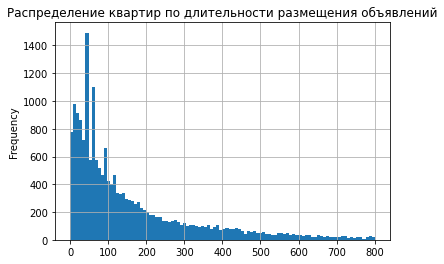

In [148]:
data_days_exposition['days_exposition'].plot(kind ='hist', bins=100, range=(0,800), grid=True,
                              title='Распределение квартир по длительности размещения объявлений')
plt.show()

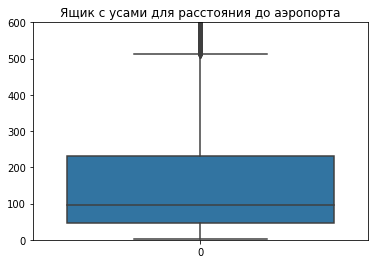

In [149]:
sns.boxplot(data=data_days_exposition['days_exposition'])
plt.ylim(0, 600)
plt.title('Ящик с усами для расстояния до аэропорта')
plt.show()

In [150]:
box_mustache(data_days_exposition['days_exposition']);

Максимальное значение усов, после которого идут выбросы: 512.


После начального анализа, можно сделать вывод, что:

- среднее значение срока размещения объявлений 181 день;
- медианное значение 96 дней;
- минимальное значение 1 день, что, конечно же очень быстро и маловероятно;
- иаксимальное значение 1572 дня.

Слишком большой разброс значений. Думаю объявления, которые находятся за значениями ящика с усами можно считать как аномалии. В данном случае после 512 дней размещения объявлений начинаются выбросы. 

Также странно, что есть выбивающиеся значения. Посмотрим получше данный отрезок.

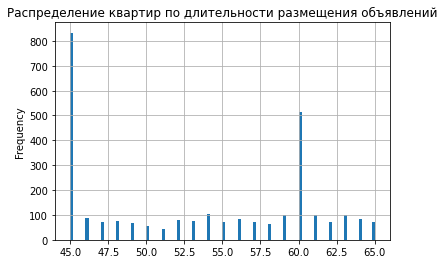

In [151]:
data_days_exposition['days_exposition'].plot(kind ='hist', bins=100, range=(45,65), grid=True,
                              title='Распределение квартир по длительности размещения объявлений')
plt.show()

- Можно предположить, что риелторские компании снимают объявления квартир в один день, поэтому получаются такие выбросы. 
-Также это может быть связано с тем, что в эти даты автоматически объявления переходят в архив, и для того чтобы дальше было показано объявление, необходимо произвести определенное действие. Система убирает с показа бесплатные объявления.

В нашем исследовании быстрыми продажами можно считать все продажи, которые находятся ниже 25% выборки, меньше 45 дней. Необычно долгими продажами можно считать все, что находится выше 75% выборки, начинная с 232 дней.

### Влияние факторов на стоимость объекта

#### Зависимость цены объекта от общей площади

In [152]:
total_area_data = data.pivot_table(index=data.index, values=['last_price','total_area'], 
                                   aggfunc='median').reset_index(drop=True)

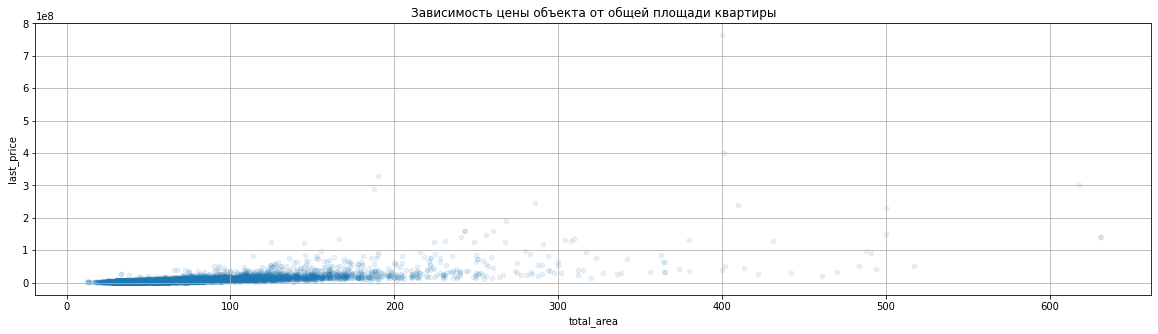

In [153]:
total_area_data.plot(x='total_area', y='last_price',kind='scatter',figsize=(20,5), grid=True, alpha=0.1,
                      title='Зависимость цены объекта от общей площади квартиры')
plt.show()

Можно вспомнить, что есть выбросы, которые можно отфильтровать. В столбце `total_area` можно убрать все значения выше 114 метров, а в столбце `last_price` больше 11 795 000.

In [154]:
total_area_data = total_area_data.query('(total_area <= 114) & (last_price <= 11795000)').copy()

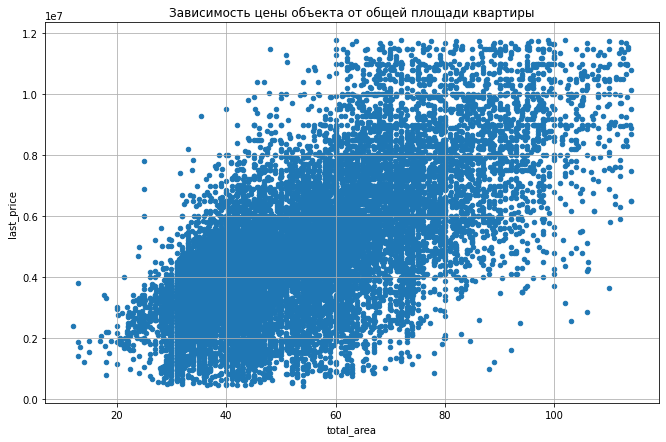

In [155]:
total_area_data.plot(x='total_area', y='last_price',kind='scatter',figsize=(11,7), grid=True, alpha=1,
                      title='Зависимость цены объекта от общей площади квартиры')
plt.show()

Можно сделать вывод, что основная масса значений приходится на значения до 8 миллионов, и 80 кв.м. С возрастанием площади, цена растет. После 80 метров квадратных резко снижается ликвидность, мало квартир и цены выше.

#### Зависимость цены объекта от жилой площади

Вспомним, что у нас есть пропуски в столбце `living_area`, поэтому избавимся сначала от них.

In [156]:
data_living_area = data.dropna(subset=['living_area']).reset_index(drop=True)

In [157]:
data_living_area = data_living_area.pivot_table(index=data_living_area.index, values=['last_price', 'living_area'],
                                                aggfunc='median').reset_index(drop=True)

Сразу учтем выбросы, которые мы нашли при исследовательском анализе в жилой площади. Отфильтруем значения, которые больше 78.

In [158]:
data_living_area = data_living_area.query('(living_area <= 78) &(last_price <= 11795000)').copy()

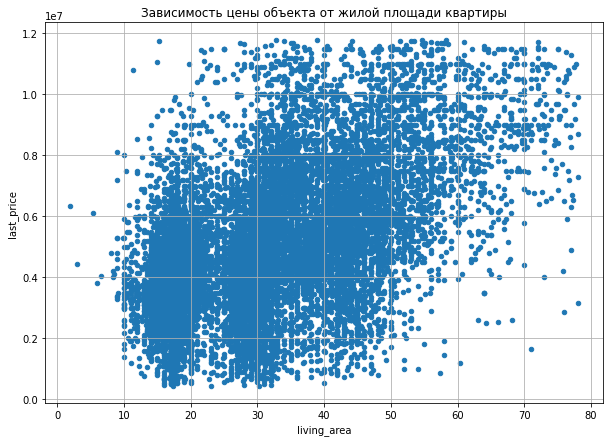

In [159]:
data_living_area.plot(x='living_area', y='last_price',kind='scatter',figsize=(10,7), grid=True, alpha=1,
                         title='Зависимость цены объекта от жилой площади квартиры')
plt.show()

До 50 метров жилой площади особо не меняется стоимость жилья, но отчетливо видна тенденция к повышению цены в зависимости от жилой площади. Также стоит отметить, что большинство значений также находится до 8 млн и в пределах жилой площади равной 50 кв. м.

#### Зависимость цены объекта от площади кухни

In [160]:
data_kitchen_area = data.dropna(subset=['kitchen_area']).reset_index(drop=True)

In [161]:
data_kitchen_area = data_kitchen_area.pivot_table(index=data_kitchen_area.index,
                                                  values=['last_price', 'kitchen_area'],
                                                  aggfunc='median').reset_index(drop=True)

In [162]:
data_kitchen_area = data_kitchen_area.query('(kitchen_area <= 20) &(last_price <= 11795000)').copy()

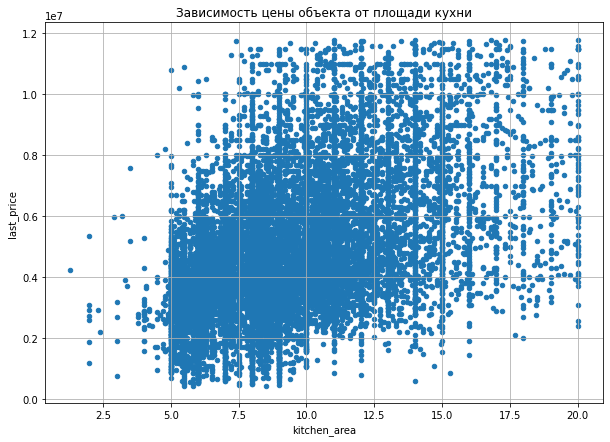

In [163]:
data_kitchen_area.plot(x='kitchen_area', y='last_price',kind='scatter',figsize=(10,7), grid=True, alpha=1,
                         title='Зависимость цены объекта от площади кухни')
plt.show()

Как и во всей площади, здесь такая же зависимость, при увеличении площади кухни, можно увидеть рост значений цены квартиры. Здесь мы также учли выбросы. Видно, что самы популярные значения площади кухни до 12.5 кв. м.

#### Зависимость цены объекта от количества комнат

Вспомним, что у нас также есть выбросы, количество комнат не более 6.

In [164]:
data_rooms = data.query('(rooms <= 6) &(last_price <= 11795000)').copy()

In [165]:
data_rooms = data_rooms.pivot_table(index=data_rooms.index, values=['last_price', 'rooms'],
                                    aggfunc='median').reset_index(drop=True)

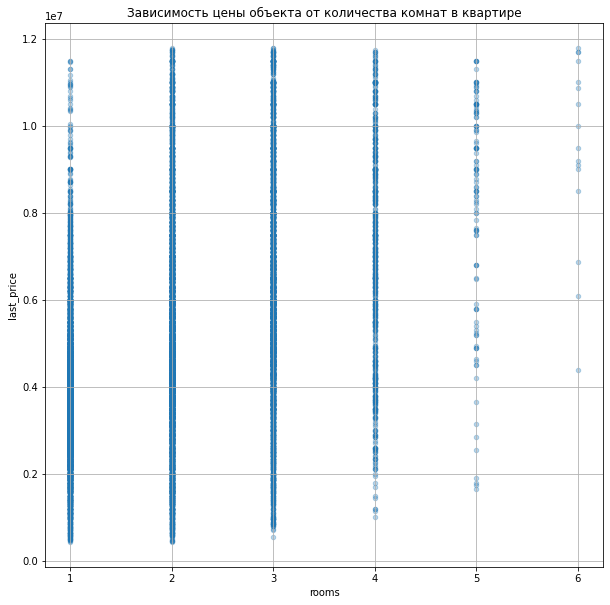

In [166]:
data_rooms.plot(x='rooms', y='last_price',kind='scatter',figsize=(10,10), grid=True, alpha=0.3,
               title='Зависимость цены объекта от количества комнат в квартире')
plt.show()

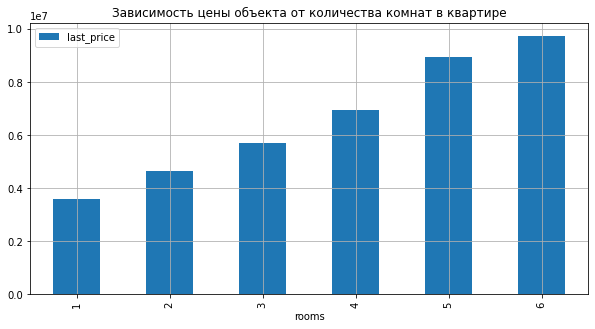

In [167]:
data_rooms.groupby('rooms').median().plot.bar(figsize=(10,5), grid=True,
                                            title='Зависимость цены объекта от количества комнат в квартире');

По графику видно, что по цене квартиры дороже, если больше комнат. Есть прямая зависимость цены квартиры от количества комнат.

#### Зависимость цены объекта от типа этажа квартиры

In [168]:
data_type_floor = data.query('last_price <= 11795000')

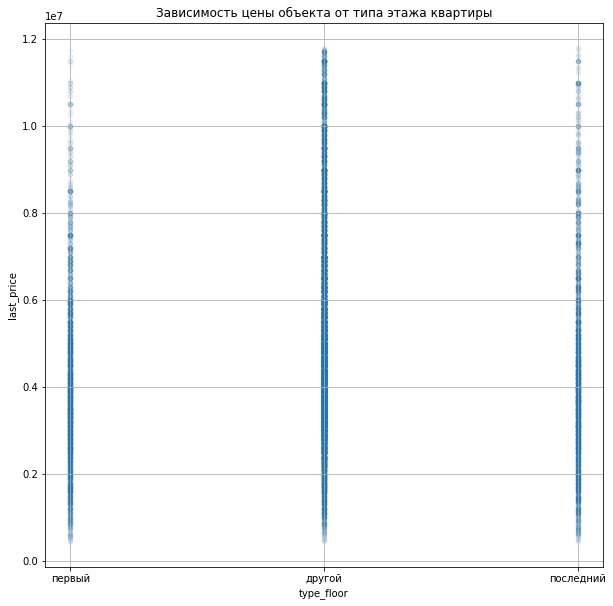

In [169]:
data_type_floor.plot(x='type_floor', y='last_price',kind='scatter',figsize=(10,10), grid=True, alpha=0.05,
               title='Зависимость цены объекта от типа этажа квартиры')
plt.show()

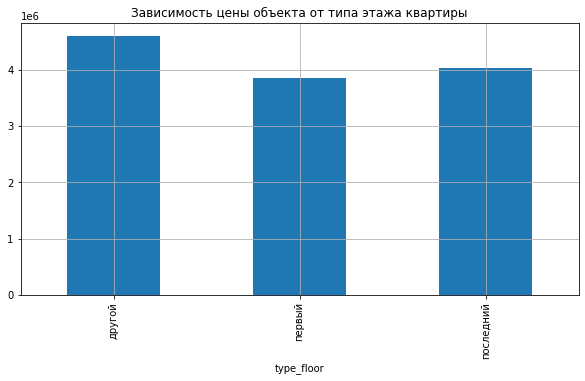

In [170]:
data_type_floor.groupby('type_floor')['last_price'].median().plot.bar(grid=True, figsize=(10,5),title='Зависимость цены объекта от типа этажа квартиры');

Первые этажи стоят дешевле, чем последнии. В сравнении с категорие "другой" и последний, и первый этажи уступают, т.к. их намного больше. 

Можно сделать вывод, что цена этажей, кроме первого и последнего, более высокая.

#### Зависимость цены объекта от даты размещения

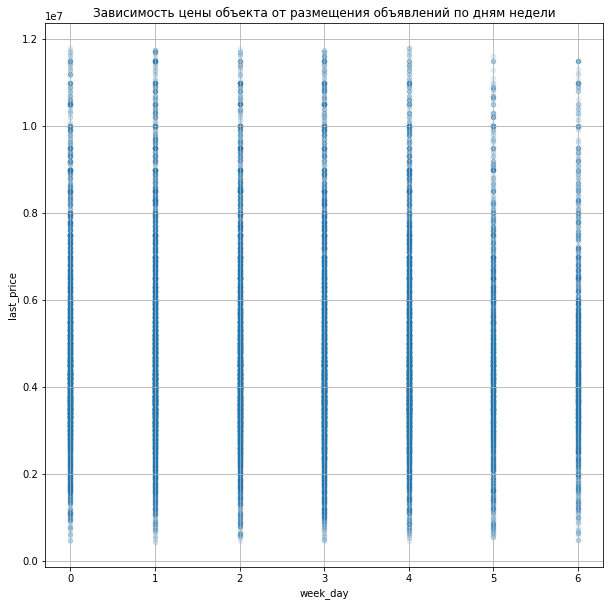

In [171]:
data_type_floor.plot(x='week_day', y='last_price',kind='scatter',figsize=(10,10), grid=True, alpha=0.1,
               title='Зависимость цены объекта от размещения объявлений по дням недели')
plt.show()

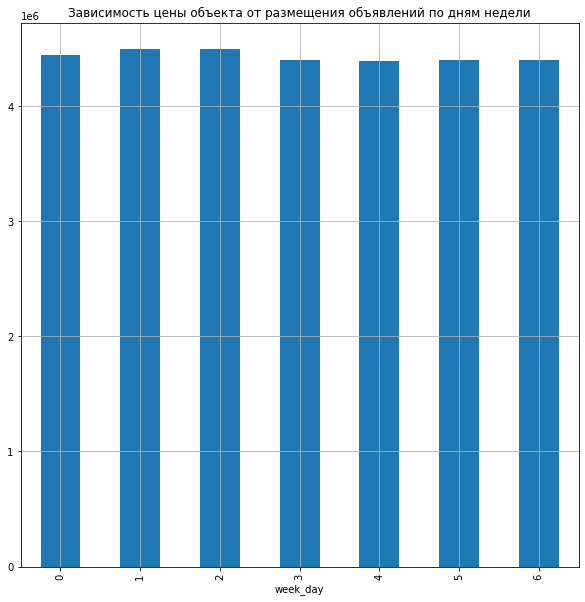

In [172]:
data_type_floor.groupby('week_day')['last_price'].median().plot.bar(grid=True, figsize=(10,10),title='Зависимость цены объекта от размещения объявлений по дням недели');

Видно, что объекты выставленные на продажу во вторник и среду имеют медианную цену выше чем объекты выставленные на продажу в другие дни.

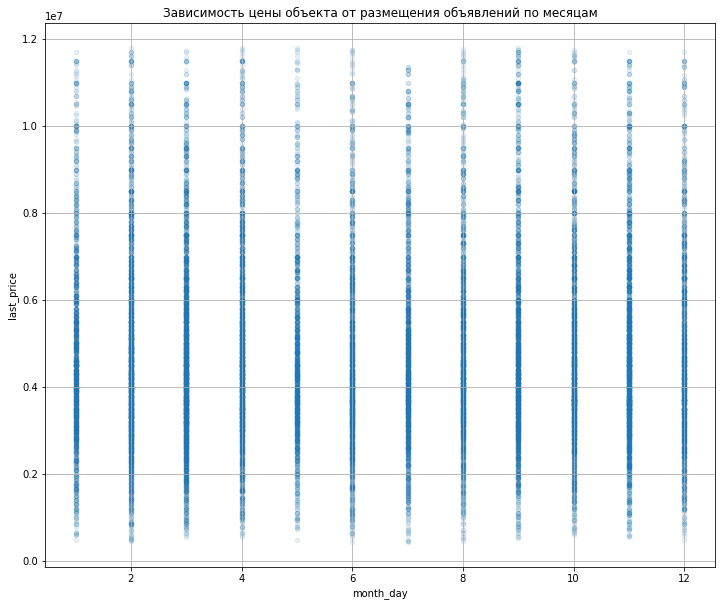

In [173]:
data_type_floor.plot(x='month_day', y='last_price',kind='scatter',figsize=(12,10), grid=True, alpha=0.1,
               title='Зависимость цены объекта от размещения объявлений по месяцам')
plt.show()

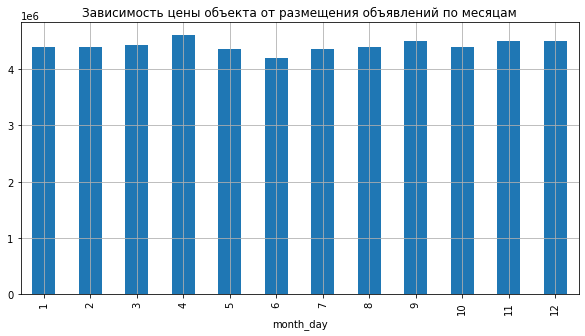

In [174]:
data_type_floor.groupby('month_day')['last_price'].median().plot.bar(grid=True, figsize=(10,5),title='Зависимость цены объекта от размещения объявлений по месяцам');

Из графика следует, что дороже всего объявления, которые выкладывают в апреле, т.к. медианные значения в данном столбце выше, чем у остальных, самая минимальная цена в июне.

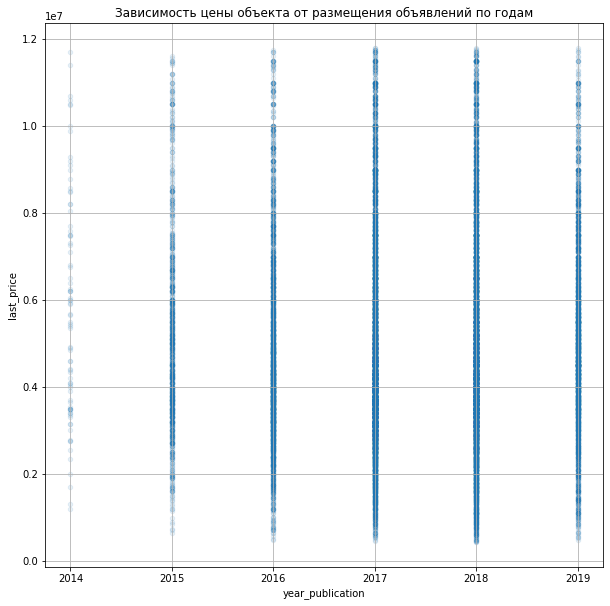

In [175]:
data_type_floor.plot(x='year_publication', y='last_price',kind='scatter',figsize=(10,10), grid=True, alpha=0.1,
               title='Зависимость цены объекта от размещения объявлений по годам')
plt.show()

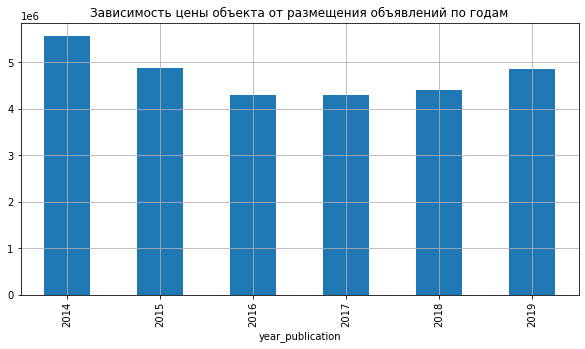

In [176]:
data_type_floor.groupby('year_publication')['last_price'].median().plot.bar(grid=True, figsize=(10,5),title='Зависимость цены объекта от размещения объявлений по годам');

График показывает нам, что с 2014 года был падающий тренд цен, в 2018 начался рост цен на объекты. В 2016-2017 годах были размещены объявления, в которых медианные значения ниже чем в другие года. В 2014-2015 годах объявлений было значитеьно меньше.

###  Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

In [177]:
meter_price_by_loc = data.groupby('locality_name')\
            .agg({'price_meter': 'mean', 'locality_name': 'count'})\
            .rename({'locality_name': 'n_records'}, axis=1)

In [178]:
most_publications = meter_price_by_loc.sort_values(by='n_records',ascending=False).head(10)

In [179]:
most_publications

,price_meter,n_records
locality_name,,
Санкт-Петербург,114712.420824,14835
Мурино,85425.028954,525
Кудрово,95244.708999,435
Шушары,78542.051918,418
Всеволожск,68750.849261,377
Пушкин,103166.584405,349
Колпино,75235.138133,323
Парголово,90224.260175,321
Гатчина,68530.193756,290


Стоимость в 10 населённых пунктах.

In [180]:
max_price_meter = most_publications['price_meter'].max()

In [181]:
most_publications.query('price_meter == @max_price_meter')

,price_meter,n_records
locality_name,,
Санкт-Петербург,114712.420824,14835


In [182]:
min_price_meter = most_publications['price_meter'].min()

In [183]:
most_publications.query('price_meter == @min_price_meter')

,price_meter,n_records
locality_name,,
Выборг,58042.385444,229


Максимальная цена квадратного метра в городе Санкт-Петербург. Минимальная в Выборге.

### Средняя цена каждого километра

In [184]:
center_kmeter_price = data.query('(cityCenters_km > 0)&(last_price <= 11795000 )')

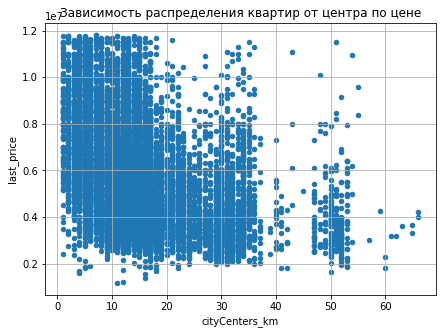

In [185]:
center_kmeter_price.plot(x='cityCenters_km', y='last_price', kind='scatter', grid=True, figsize=(7,5), alpha =1,
               title='Зависимость распределения квартир от центра по цене')
plt.show() 

In [186]:
center_kmeter_price_spb = center_kmeter_price.query('locality_name == "Санкт-Петербург"').copy()

In [187]:
center_kmeter_price_spb['median_price_km'] = center_kmeter_price_spb['last_price']/center_kmeter_price_spb['cityCenters_km']

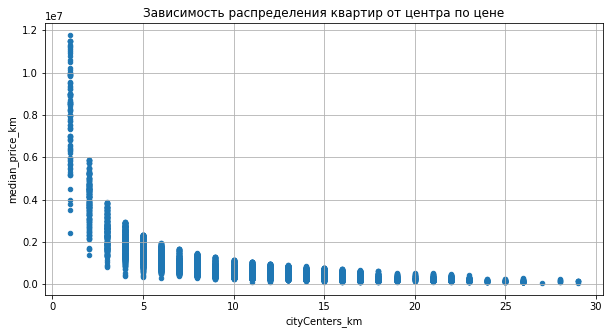

In [188]:
center_kmeter_price_spb.plot(x='cityCenters_km', y='median_price_km', kind='scatter', figsize=(10,5),
                             grid=True, alpha =1, title='Зависимость распределения квартир от центра по цене')
plt.show()

По построенной гистограмме можно увидеть, что средняя цена за километр тем выше, чем ближе к центру.

Также можно построить простой линейный график, который покажет, как средняя цена за километр меняется с расстоянием.

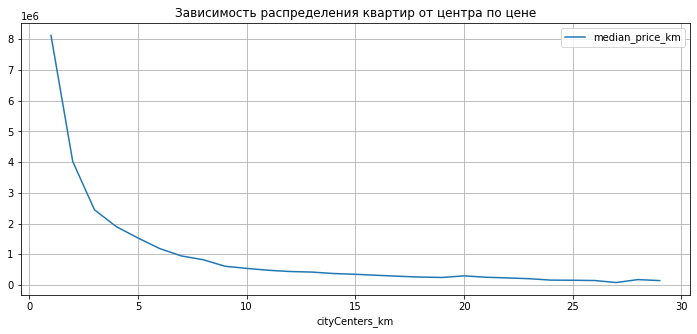

In [189]:
(
    center_kmeter_price_spb.pivot_table(index='cityCenters_km', values='median_price_km')
    .plot(grid=True, figsize=(12, 5), title='Зависимость распределения квартир от центра по цене')
) 
plt.show()

# Общий вывод

Работа представляла собой исследовательский анализ данных сервиса Яндекс Недвижимость. Первым делом было принято решение посмотреть, какие данные представлены в архиве. Далее необходимо было провести предобработку данных, в которой было выявлено, что:

- в данном проекте можно столкнуться со множеством пропусков, возможно некоторые данные были утеряны, в особенности картографические. Несколько строк было удалено, т.к. количество пропусков в них составляло очень малений процент от всех данных, были произведены замены пустых значений, а также присваивание определенных маркеров `-1`, для корректной обработки данных;
- в датафрейме было выявленно несколько столбцов с неправильным типом данных, которые были изменены;
- при поиске дубликатов оказалось, что несколько населенных пунктов с одинаковым название записаны по-разному. После анализа данных было принято решение заменить строки на названия населенных пунктов без приставок к названиям;
- в работе было выявлено множество аномалий, которые в последствии были отфильтрованы при исследовательском анализе. Было несколько квартир с 0-м этажом, с потолками по 20 метров и более чем 10-ю комнатами. В обработке аномалий были исключены некоторые значения, а некоторые приведны к нормальному виду;
- в датафрейм были добавлены некоторые полезные столбцы, с помощью которых можно было проанализировать необычные данные.

После предобработки данных был проведен исследовательский анализ данных проекта. Были построены гистограммы и проведен анализ практически каждого столбца. Некоторые выводы из анализа: 

- количество размещенных объявлений с квартирами на этажах кроме первого и последнего больше;
- в среднем общая площадь квартир составила 60 кв.м.;
- жилая площадь 34 кв.м.;
- площадь кухни  10.5 кв. м.;
- большинство квартир, размещенных в объявлениях, имеют стоимость от 3.5 млн до 4 млн;
- больше всего однокомнатных и двухкомнантных квартир;
- высота потолков от 2.5 м до 2.75 м;
- в среднем квартиру удается продать за 90 дней.

Также стоит отметить, что чем больше площадь квартиры, тем выше цены. В последнем разделе было выявлено, что цена одного кв. м. самая дорогая в Санкт-Петербурге, самая дешевая из 10 самых популярных насёленных пунктов в Выборге. В раблте были рассчитаны средние значения стоимости одного километра и было выявлено, что, чем ближе квартира к центру, тем дороже стоимость квартиры.